# 1. 预处理

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from pathlib import Path
from typing import Optional, List
from torchvision.transforms.v2.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from torchvision.utils import flow_to_image
import pickle
from torchcodec.decoders import VideoDecoder
import cv2
import ot
import tempfile
import open_clip
import imageio
from IPython.display import Video, display

In [41]:
import os
import json
import pickle
import random
import matplotlib.pyplot as plt
import os, sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from evaluate import (
    VideoClip,
    get_saliency_score,
    get_motion_score,
    get_embeddings_score
)


# ========== 工具函数部分 ==========

def load_video_ids(json_path, limit=None):
    """读取 jsonl 文件中的 video_id 列表"""
    ids = []
    with open(json_path, "r") as f:
        for line in f:
            shots = json.loads(line)["shots"]
            if len(shots) <= 100:
                ids.append(json.loads(line)["video_id"])
    return ids[:limit] if limit else ids


def load_clips(video_id):
    """加载某个视频的 clips.pkl"""
    # os.system(f"cd .. && python evaluate.py videos/mashup/{video_id} --recalc")

    clips_path = f"../output/videos/mashup/{video_id}/clips.pkl"
    if not os.path.exists(clips_path):
        # print(f"[Skip] clips.pkl not found: {video_id}")
        return None
    with open(clips_path, "rb") as f:
        return pickle.load(f)


def _extract_top_flows(flow_field, top_ratio):
    u = flow_field[0].reshape(-1)
    v = flow_field[1].reshape(-1)
    mag = np.sqrt(u**2 + v**2)
    k = max(1, int(len(mag) * top_ratio))
    idx = np.argpartition(mag, -k)[-k:]
    top_u = u[idx]
    top_v = v[idx]
    return (np.mean(top_u), np.mean(top_v))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_motion_score(clip1, clip2, top_ratio=0.05):    
    (u1, v1) = _extract_top_flows(clip1.end_flow, top_ratio)
    (u2, v2) = _extract_top_flows(clip2.start_flow, top_ratio)
    m1 = np.sqrt(u1**2+v1**2)
    m2 = np.sqrt(u2**2+v2**2)
    mag_sim = 1 - np.tanh(np.abs(m1 - m2) / 80.0)
    dir_sim = np.abs((u1 * u2 + v1 * v2) / (m1 * m2))
    dir_conf = (m1 / (m1 + 2)) * (m2 / (m2 + 2))
    # dir_conf = sigmoid((m1 - 8) / 2) * sigmoid((m2 - 8) / 2)
    # print(m1, m2)
    # print(mag_sim, dir_sim, dir_conf)
    return mag_sim * (1 - dir_conf) + dir_sim * dir_conf

def compute_pair_scores(c1, c2):
    """对两个 clip （或任意片段对象）计算三个得分"""
    return (
        get_saliency_score(c1, c2),
        get_embeddings_score(c1, c2),
        get_motion_score(c1, c2),
    )


def plot_distribution(values, title):
    """画一个直方图"""
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=50, range=(0,1), alpha=0.75)
    plt.title(title)
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.ylim(0, 500)
    plt.grid(True)
    plt.show()


def print_overall_stats(name, values):
    """打印平均值"""
    print(f"{name} Average Score: {sum(values)/len(values):.4f}")


# 2. 测试 human-made videos

=== Human-made Video Score Distributions ===
6556
Composition Average Score: 0.7851
Semantic Average Score: 0.9402
Motion Average Score: 0.7109


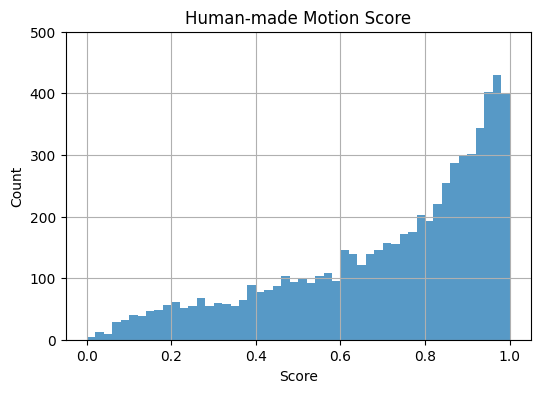

In [42]:
# ========== Human-made 视频实验 ==========

mashup_json_path = "../data/json/mashup.json"
video_ids = load_video_ids(mashup_json_path, 100)

all_saliency_scores = []
all_embeddings_scores = []
all_motion_scores = []

for vid in video_ids:
    if vid == "NsMtId_KZY8":
        continue
    clips = load_clips(vid)
    if clips is None or len(clips) < 2:
        continue

    for k in range(len(clips) - 1):
        try:
            s_sal, s_emb, s_mot = compute_pair_scores(clips[k], clips[k+1])
            all_saliency_scores.append(s_sal)
            all_embeddings_scores.append(s_emb)
            all_motion_scores.append(s_mot)
        except Exception as e:
            print(f"[Error] scoring failed for {vid}: {e}")


print("=== Human-made Video Score Distributions ===")
print(len(all_saliency_scores))
print_overall_stats("Composition", all_saliency_scores)
print_overall_stats("Semantic", all_embeddings_scores)
print_overall_stats("Motion", all_motion_scores)

# plot_distribution(all_saliency_scores, "Human-made Composition Score")
# plot_distribution(all_embeddings_scores, "Human-made Semantic Score")
plot_distribution(all_motion_scores, "Human-made Motion Score")


# 3. 测试随机拼接

=== Random Clip Pair Distributions ===
Random Composition Average Score: 0.7665
Random Semantic Average Score: 0.6098
Random Motion Average Score: 0.6767


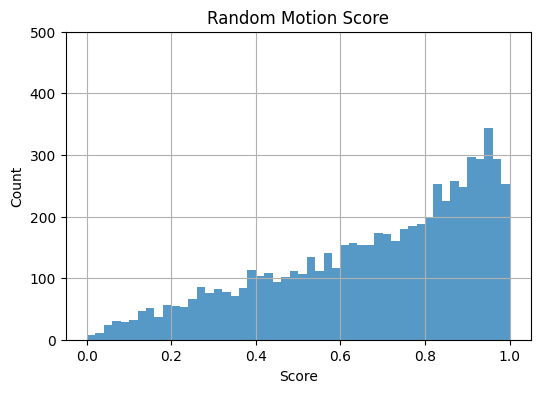

In [43]:
# ========== Random 拼接实验 ==========

N = 6556   # 你可以修改随机次数
random_sal = []
random_emb = []
random_mot = []

# 预加载所有 clips，避免重复读取
vid2clips = {}
for vid in video_ids:
    c = load_clips(vid)
    if c is not None and len(c) > 0:
        vid2clips[vid] = c

valid_video_ids = list(vid2clips.keys())

for _ in range(N):
    vid1, vid2 = random.sample(valid_video_ids, 2)
    clips1 = vid2clips[vid1]
    clips2 = vid2clips[vid2]

    c1 = random.choice(clips1)
    c2 = random.choice(clips2)

    try:
        s_sal, s_emb, s_mot = compute_pair_scores(c1, c2)
        random_sal.append(s_sal)
        random_emb.append(s_emb)
        random_mot.append(s_mot)
    except Exception as e:
        print(f"[Error] random scoring failed: {e}")
        continue

print("=== Random Clip Pair Distributions ===")
print_overall_stats("Random Composition", random_sal)
print_overall_stats("Random Semantic", random_emb)
print_overall_stats("Random Motion", random_mot)

# plot_distribution(random_sal, "Random Composition Score")
# plot_distribution(random_emb, "Random Semantic Score")
plot_distribution(random_mot, "Random Motion Score")
